In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, SimpleRNN

# time step만큼 시퀀스 데이터 분리
def split_sequence(sequence, step):
  x, y = list(), list()

  for i in range(len(sequence)):
    end_idx = i + step
    if end_idx > len(sequence) - 1:
      break

    seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
    x.append(seq_x)
    y.append(seq_y)

  return np.array(x), np.array(y)


# sin 함수 학습 데이터
x = [i for i in np.arange(start=-10, stop=10, step=0.1)]
train_y = [np.sin(i) for i in x]

# 6.3 개체명 인식을 위한 양방향 LSTM 모델

이번에는 챗봇 엔진에 **개체명 인식(named entity recognition)**을 위해 사용하는 **양방향 LSTM(Bi-LSTM)**에 대해 알아봅시다.

### **LSTM**

순환 신경망 모델의 일종으로 **시퀀스 또는 시계열 데이터**의 패턴을 인식하는 분야에 많이 사용됩니다.

연속적인 데이터의 패턴을 이용해 결과를 예측하므로 주로 주가 예측이나 신호 분석 및 번역 분야에서 좋은 성능을 보입니다.

## 6.3.1 RNN 

### **RNN(Recurrent Neural Network)**

LSTM은 RNN 모델에서 파생되었습니다. RNN은 순환 신경망으로 불리며, 앞서 배운 신경망 모델과 다르게 **은닉층 노드의 출력값을 출력층과 그다음 시점의 은닉층 노드의 입력으로 전달**해 순환하는 특징을 갖고 있습니다.
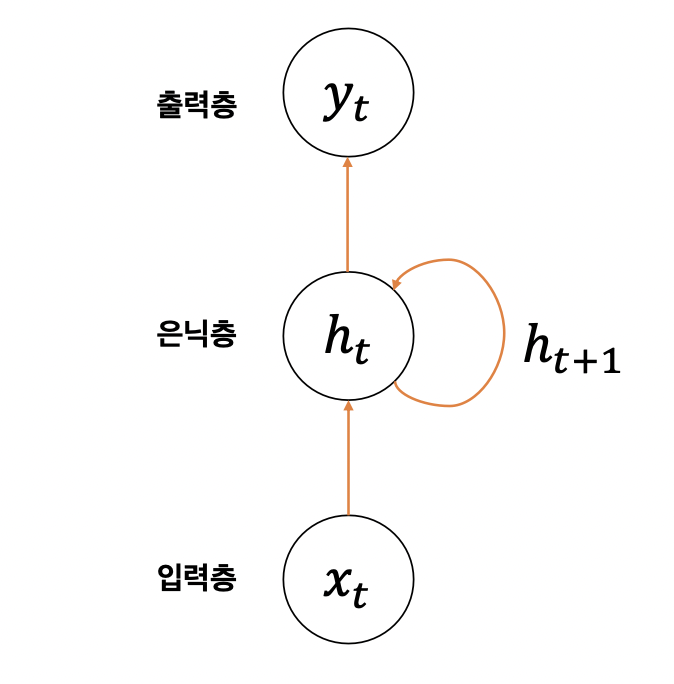

### RNN의 특징

- $t$는 현재 시점을 의미하고  $x_t$는 현재 시점의 입력 벡터, $y_t$는 현재 시점의 출력 벡터를 의미합니다.
- **셀(메모리 셀)**: 은닉층 노드에서 이전 시점($t$-1)의 상탯값을 저장하는 메모리 역할을 수행합니다.
- **은닉 상태(hidden state)**: 메모리 셀의 출력 벡터가 출력층과 다음 시점($t$+1)의 메모리 셀에 전달되는 상태
- $h_t$는 현재 시점의 은닉 상태, $h_{t+1}$은 다음 시점의 은닉 상태를 의미합니다.

### 시점의 흐름에 따른 RNN 모델 표현

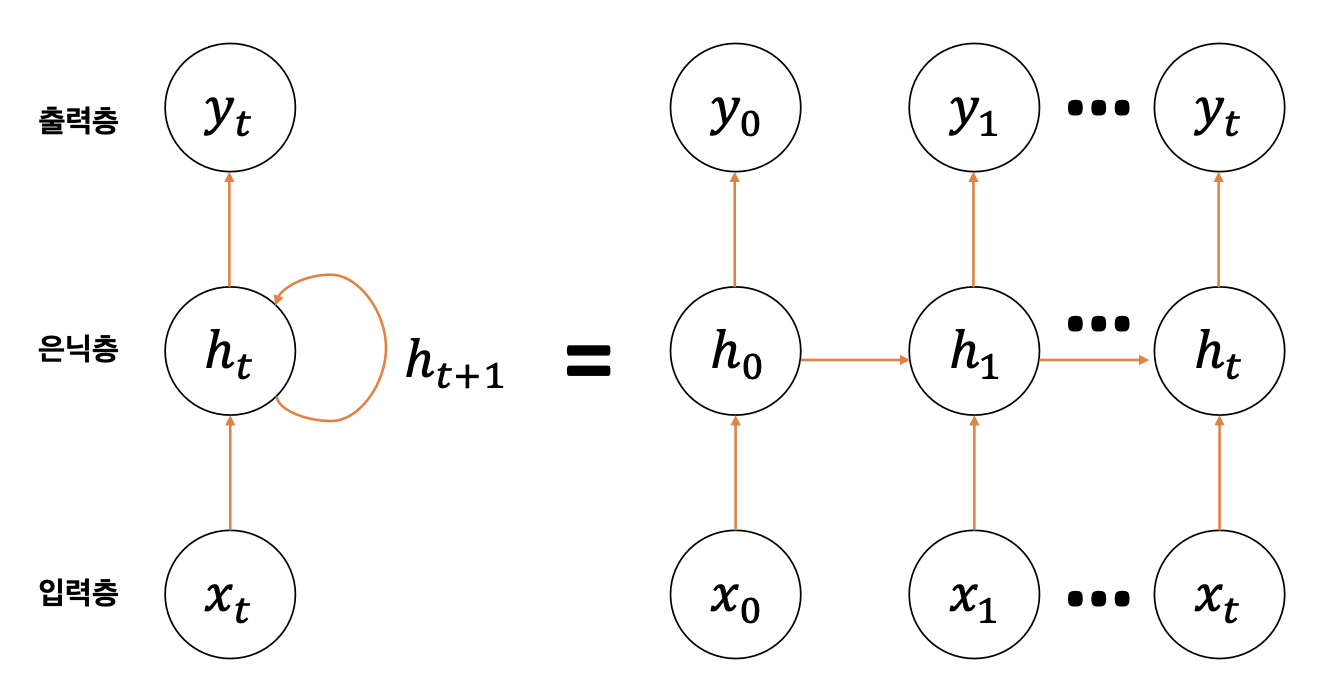

❗️**중요**❗️

**현재 시점의 메모리 셀은 이전 시점의 은닉 상탯값에 영향을 받고 있으며 완전 연결 계층 구조를 가지고 있다**는 것입니다.

### 입력과 출력의 길이에 따른 RNN 모델 예시

1) **many-to-one:** 여러 개를 입력 받아 하나를 출력
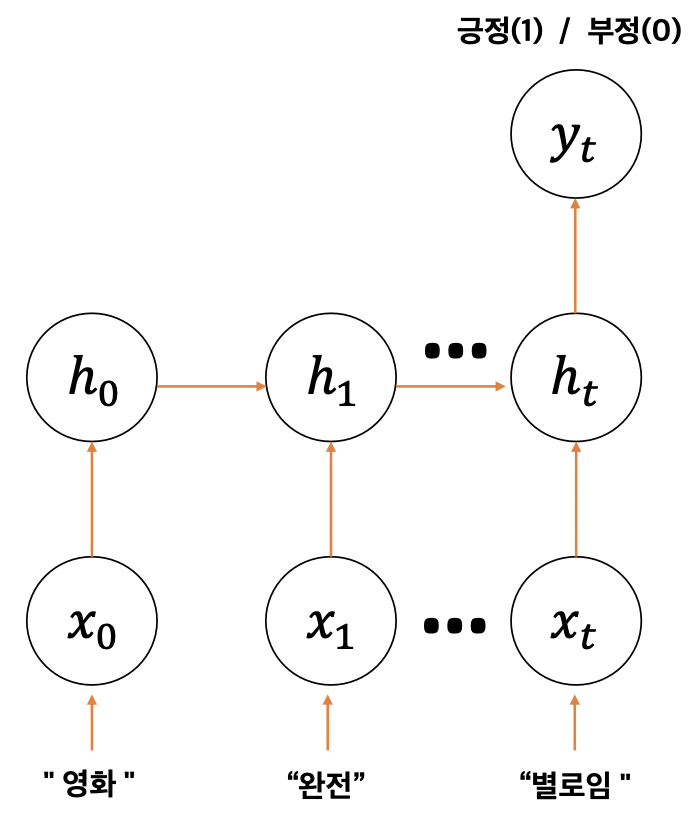
- 문장 시퀀스를 입력받아 해당 문장이 긍정인지 부정인지 분류하는 문제의 예시입니다.

2) 하나를 입력받아 여러 개를 출력하는 **one-to-man
y** 모델
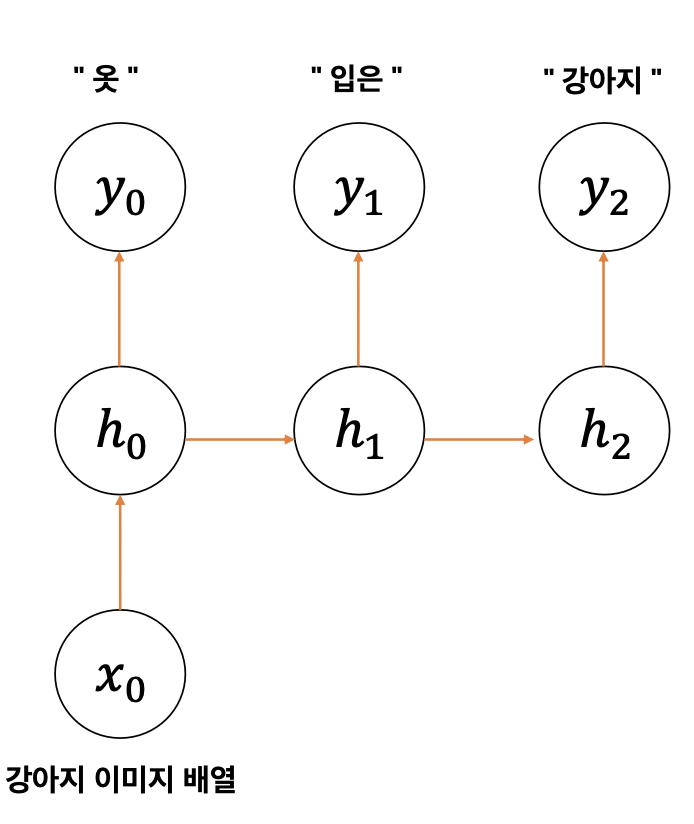

- 한 장의 이미지를 입력받아 이미지를 설명하는 텍스트를 출력하는 모델로 사용할 수 있습니다.

3) 여러 개를 입력받아 여러 개를 출력하는 many-to-many 
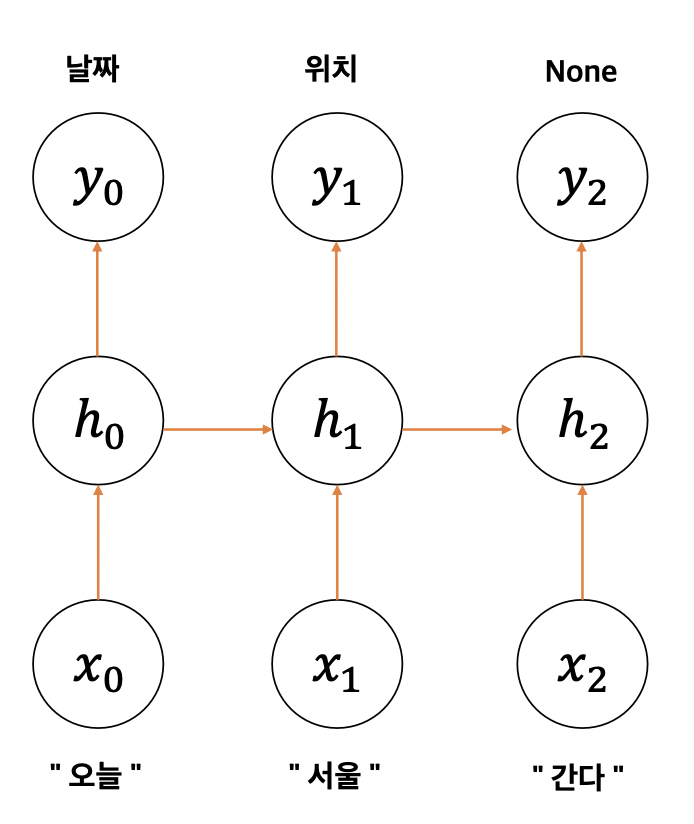

- 이 모델은 우리가 앞으로 구현할 개체명 인식기에도 사용하는 모델입니다.
- 단어 시퀀스를 입력으로 받아 각 시퀀스가 의미하는 개체명을 출력하는 구조로 번역기 모델로도 사용 가능합니다.

### RNN 모델의 파라미터
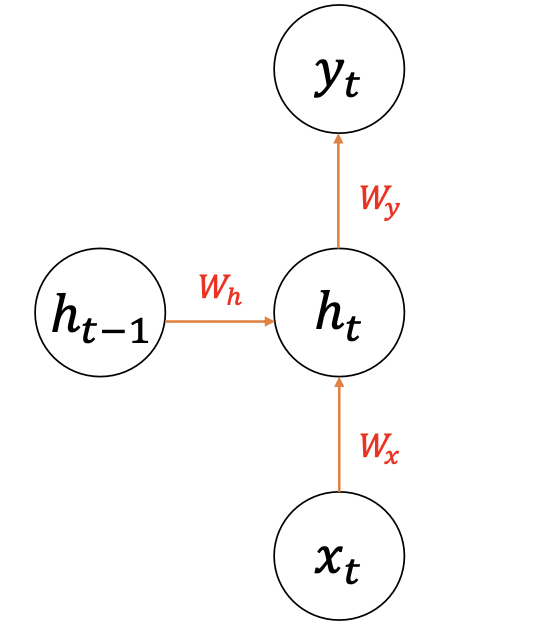
RNN이 수식적으로 어떻게 동작하는지 알아봅시다.

$x_t$, $y_t$, $h_t$는 앞서 설명한 의미와 같고 $w_x$는 입력 $x_t$에 대한 가중치, $w_h$는 이전 시점의 은닉 상탯값인 $h_{t-1}$에 대한 가중치, $w_y$는 현재 시점의 은닉 상탯값인 $h_t$에 대한 가중치입니다.

- 은닉층: $h_t=tanh(w_xx_t+w_hh_{t-1}+b_h)$
- 출력층: $y_t=w_yh_t + b_y$

현재 시점의 은닉 상탯값 $h_t$는 활성화 함수인 하이퍼블릭 탄젠트($tanh$)를 사용하여 현재 입력값과 이전 시점의 은닉 상태값으로 계산합니다. 이때 **이전 시점의 은닉 상탯값이 현재 시점의 은닉 상태에 계속해서 영향**을 주기 때문에 시퀀스 데이터의 특징을 잘 파악할 수 있습니다.

마지막으로 출력층 $y_t$는 메모리 셀에서 계산된 은닉 상탯값 $h_t$와 가중치 $w_y$를 곱한 값으로 계산합니다.

### RNN 모델 구현 실습

특정 범위만큼의 $sin$ 파형 시퀀스를 학습해 다음 스텝의 파형을 예측하는 RNN 모델 구현을 해봅시다.

-10에서 +10 사이의 x축 범위를 가지는 sin() 함수 값을 0.1 단위로 증가시켜 train_y 리스트에 저장합니다. 

In [ ]:
# 하이퍼파라미터
n_timesteps = 15
n_features = 1

# 시퀀스 나누기
# train_x.shape => (samples, timesteps)
# train_y.shape => (samples)
train_x, train_y = split_sequence(train_y, step=n_timesteps)
print("shape x:{} / y:{}".format(train_x.shape, train_y.shape))

shape x:(185, 15) / y:(185,)


RNN 모델에서 사용하는 입력 시퀀스 길이(n_timesteps)를 15로 정의하고, 입력 벡터의 차원 크기는(n_features)는 1로 정의합니다. 이때 n_timesteps만큼 RNN 메모리 셀이 생성됩니다.

그 후 split_sequence() 함수를 호출해 입력 시퀀스를 만들고, sin 파형의 학습 데이터가 들어있는 train_y 리스트에서 n_timesteps만큼 입력 시퀀스를 생성합니다.

In [ ]:
# RNN 입력 벡터 크기를 맞추기 위해 벡터 차원 크기 변경
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
print("train_x.shape = {}".format(train_x.shape))
print("train_y.shape = {}".format(train_y.shape))

train_x.shape = (185, 15, 1)
train_y.shape = (185,)


케라스에서 RNN 계층을 사용하려면 3차원 텐서 형태여야 합니다. 따라서 2차원(samples, time step)인 train_x를 3차원(batch size, time step, input length) 형태로 변환합니다.

In [ ]:
# RNN 모델 정의
model = Sequential()
model.add(SimpleRNN(units=10,
                    return_sequences=False,
                    input_shape=(n_timesteps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

sin 파형 데이터셋을 학습하기 위한 모델로는 가장 간단한 형태의 RNN 계층인 SimpleRNN 계층 1개와 출력을 위한 Dense 계층 1개로 구성되어 있습니다. 

- units: RNN 계층에 존재하는 전체 뉴런 수
- return_sequences: 앞서 배운 RNN 계산 과정에서 은닉 상탯값을 출력할지 결정 (false: 마지막 시점의 메모리 셀에서만 결과 출력 / True: 모든 RNN 계산 과정에서 결과 출력)

손실 함수로는 mse를 사용하며 옵티마이저로는 adam을 사용하여 최적화합니다.

In [ ]:
# 모델 학습
np.random.seed(0)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    mode='auto'
)
history = model.fit(train_x, train_y, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
6/6 [==============================] - 2s 12ms/step - loss: 0.1082
Epoch 2/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0369
Epoch 3/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 4/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0117
Epoch 5/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 6/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0105
Epoch 7/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.0082
Epoch 8/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 9/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.0072
Epoch 10/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.0067
Epoch 11/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 12/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 13/1000
6/6 [===========================

생성한 모델을 실제 학습합니다. 이번 예제에서는 검증용 데이터셋은 생략하였고, 오버피팅을 피하기 위해 손실(loss)이 갑자기 증가되는 시점을 찾을 수 있는 조기 종료(EarlyStopping) 콜백 객체를 사용했습니다. 예제에서는 patience=5를 통해 성능이 증가하지 않을 때 5에포크 정도 더 학습하도록 설정했습니다.

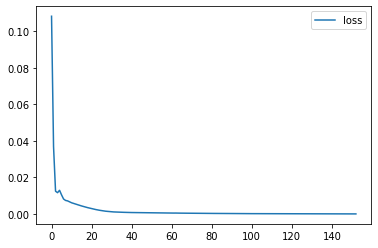

In [ ]:
# loss 그래프 생성
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

학습 에포크 증가에 따른 손실 그래프입니다. 학습이 진행될수록 손실이 줄어들고 있는 모습을 보입니다.

In [ ]:
# 테스트 데이터셋 생성
test_x = np.arange(10, 20, 0.1)
calc_y = np.cos(test_x) # 테스트 정답 데이터

# RNN 모델 예측 및 로그 저장
test_y = calc_y[:n_timesteps]
for i in range(len(test_x) - n_timesteps):
  net_input = test_y[i : i + n_timesteps]
  net_input = net_input.reshape((1, n_timesteps, n_features))
  train_y = model.predict(net_input, verbose=0)
  print(test_y.shape, train_y.shape, i, i + n_timesteps)
  test_y = np.append(test_y, train_y)

(15,) (1, 1) 0 15
(16,) (1, 1) 1 16
(17,) (1, 1) 2 17
(18,) (1, 1) 3 18
(19,) (1, 1) 4 19
(20,) (1, 1) 5 20
(21,) (1, 1) 6 21
(22,) (1, 1) 7 22
(23,) (1, 1) 8 23
(24,) (1, 1) 9 24
(25,) (1, 1) 10 25
(26,) (1, 1) 11 26
(27,) (1, 1) 12 27
(28,) (1, 1) 13 28
(29,) (1, 1) 14 29
(30,) (1, 1) 15 30
(31,) (1, 1) 16 31
(32,) (1, 1) 17 32
(33,) (1, 1) 18 33
(34,) (1, 1) 19 34
(35,) (1, 1) 20 35
(36,) (1, 1) 21 36
(37,) (1, 1) 22 37
(38,) (1, 1) 23 38
(39,) (1, 1) 24 39
(40,) (1, 1) 25 40
(41,) (1, 1) 26 41
(42,) (1, 1) 27 42
(43,) (1, 1) 28 43
(44,) (1, 1) 29 44
(45,) (1, 1) 30 45
(46,) (1, 1) 31 46
(47,) (1, 1) 32 47
(48,) (1, 1) 33 48
(49,) (1, 1) 34 49
(50,) (1, 1) 35 50
(51,) (1, 1) 36 51
(52,) (1, 1) 37 52
(53,) (1, 1) 38 53
(54,) (1, 1) 39 54
(55,) (1, 1) 40 55
(56,) (1, 1) 41 56
(57,) (1, 1) 42 57
(58,) (1, 1) 43 58
(59,) (1, 1) 44 59
(60,) (1, 1) 45 60
(61,) (1, 1) 46 61
(62,) (1, 1) 47 62
(63,) (1, 1) 48 63
(64,) (1, 1) 49 64
(65,) (1, 1) 50 65
(66,) (1, 1) 51 66
(67,) (1, 1) 52 67
(68

학습한 RNN 모델을 테스트가히 위해 테스트용 데이터셋을 생성합니다. 10에서 20 사이의 x축 범위를 가지는 cos() 함수 값을 0.1 단위로 증가시켜 calc_y 리스트에 저장합니다. (cos() 함수를 이용해 테스트용 데이터셋을 만드는 이유는 학습된 sin 파형과 주기적 차이를 주기 위해서입니다.)

학습된 RNN 모델의 예측값을 그래프로 그리기 위해 test_y 리스트에 순차적으로 저장합니다.

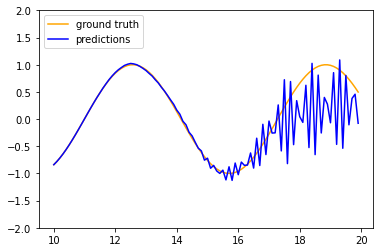

In [ ]:
# 예측 결과 그래프 그리기
plt.plot(test_x, calc_y, label="ground truth", color="orange")
plt.plot(test_x, test_y, label="predictions", color="blue")

plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()

예측 결과를 그래프로 출력한 결과입니다. 흐린 실선의 sin 파형이 테스트 데이터셋의 정답 데이터이며, 진한 실선의 sin 파형이 우리가 학습한 RNN 모델의 예측 결과입니다. 실제 정답과 오차가 거의 없이 예측되었습니다.

## 6.3.2 LSTM

앞서 살펴본 RNN 모델은 입력 시퀀스의 시점이 길어질수록 앞쪽의 데이터가 뒤쪽으로 잘 전달되지 않아 학습 능력이 떨어집니다. 또한 RNN을 다층 구조로 쌓으면 입력과 출력 데이터 사이의 연관 관계가 줄어들어 **장기 의존성(Long-Term Dependency)** 문제가 생깁니다. 이러한 문제를 보완하기 위해 기존 RNN을 변형한 **LSTM(Long Short Term Memory)**을 개발했습니다.

### LSTM의 내부 구조

LSTM은 기본적인 RNN의 은닉 상태를 계산하는 방식에 변화가 있으며, 은닉 상탯값 이외에 셀 상탯값이 추가되어 **입력 게이트(Input Gate), 삭제 게이트(Forget Gate), 출력 게이트(Output Gate)**의 3가지 게이트로 구성됩니다.

- **입력 게이트(Input Gate)**: 현재 정보를 얼마나 기억할지 결정하는 게이트
    
    $i_t=σ(w_{xi}x_t + w_{hi}h_{t-1}+b_i)$
    
    $g_t=tanh(w_{xg}x_t+w_{hg}h_{t-1}+b_g)$
    
    현재 시점의 입력값($x_t$)과 이전 시점의 은닉 상탯값($h_{t-1}$)을 연관된 가중치로 곱해 2개의 활성화 함수(시그모이드 함수와 하이퍼블릭 탄센트 함수) 계산하여 **기억할 정보의 양을 결정**합니다. 
    

- **삭제 게이트(Forget Gate)**: 이전 시점의 셀 상탯값을 삭제하기 위해 사용
    
    $f_t=σ(w_{xf}x_t+w_{hf}h_{t-1}+b_f)$
    
    현재 시점의 입력값($x_t$)과 이전 시점의 은닉 상탯값($h_{t-1}$)을 시그모이드 함수를 통해 0~1 사이의 값으로 출력하여 삭제 게이트의 결과값($f_t$)으로 기억된 정보를 얼마나 삭제할지 강도를 결정합니다.
    
    $c_t=(c_{t-1}f_t)+(i_tg_t)$
    
    입력 게이트와 삭제 게이트의 결괏값으로 현재 시점의 셀 상태를 계산합니다. 셀 상태값 $c_t$(오랫동안 정보 특성을 기억할 수 있기에 장기 상태라고도 부름)는 입력 게이트와 삭제 게이트의 결과에 영향을 미치는데, **삭제 게이트는 이전 시점의 입력을 얼마나 반영할지, 입력 게이트는 현재 시점의 입력을 얼마나 반영할지** 결정합니다.
    
- **출력 게이트(Output Gate)**: 출력 게이트의 결과값($σ_t$)이 현재 시점의 은닉 상태($h_t$)를 결정하는 데 사용되며 해당 값은 전달되는 메모리 셀이 많아질수록 정보 유실이 크기 때문에 단기 상태라고 부릅니다.
    
    $h_t=tanh(c_t)σ_t$
    
    단기 상태(은닉 상태)는 장기 상태(셀 상탯값)에 영향을 받는 구조입니다.
    

### LSTM 모델 구현 실습

RNN 모델 구현과 동일하게 특정 범위만큼의 $sin$ 파형 시퀀스를 학습해 다음 스텝의 파형을 예측하는  LSTM 모델 구현을 해봅시다.

RNN 모델 예제에서 SimpleRNN 클래스명을 LSTM으로 바꿔주기만 하면 되기 때문에 자세한 설명을 생략하겠습니다.

shape x:(185, 15) / y:(185,)
train_x.shape = (185, 15, 1)
train_y.shape = (185,)
Epoch 1/1000
6/6 [==============================] - 2s 7ms/step - loss: 0.1879
Epoch 2/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1657
Epoch 3/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1481
Epoch 4/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.1350
Epoch 5/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1251
Epoch 6/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1166
Epoch 7/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1095
Epoch 8/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1024
Epoch 9/1000
6/6 [==============================] - 0s 19ms/step - loss: 0.0960
Epoch 10/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0900
Epoch 11/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0841
Epoch 12/1000
6/6 [=======================

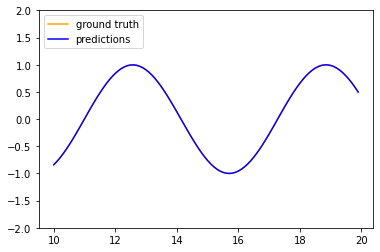

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, SimpleRNN

# time step만큼 시퀀스 데이터 분리
def split_sequence(sequence, step):
  x, y = list(), list()

  for i in range(len(sequence)):
    end_idx = i + step
    if end_idx > len(sequence) - 1:
      break

    seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
    x.append(seq_x)
    y.append(seq_y)

  return np.array(x), np.array(y)


# sin 함수 학습 데이터
x = [i for i in np.arange(start=-10, stop=10, step=0.1)]
train_y = [np.sin(i) for i in x]

# 하이퍼파라미터
n_timesteps = 15
n_features = 1

# 시퀀스 나누기
# train_x.shape => (samples, timesteps)
# train_y.shape => (samples)
train_x, train_y = split_sequence(train_y, step=n_timesteps)
print("shape x:{} / y:{}".format(train_x.shape, train_y.shape))

# LSTM 입력 벡터 크기를 맞추기 위해 벡터 차원 크기 변경
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
print("train_x.shape = {}".format(train_x.shape))
print("train_y.shape = {}".format(train_y.shape))

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=10,
                    return_sequences=False,
                    input_shape=(n_timesteps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
np.random.seed(0)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    mode='auto'
)
history = model.fit(train_x, train_y, epochs=1000, callbacks=[early_stopping])

# 테스트 데이터셋 생성
test_x = np.arange(10, 20, 0.1)
calc_y = np.cos(test_x) # 테스트 정답 데이터

# LSTM 모델 예측 및 로그 저장
test_y = calc_y[:n_timesteps]
for i in range(len(test_x) - n_timesteps):
  net_input = test_y[i : i + n_timesteps]
  net_input = net_input.reshape((1, n_timesteps, n_features))
  train_y = model.predict(net_input)
  # print(test_y.shape, train_y.shape, i, i + n_timesteps)
  test_y = np.append(test_y, train_y)

# 예측 결과 그래프 그리기
plt.plot(test_x, calc_y, label="ground truth", color="orange")
plt.plot(test_x, test_y, label="predictions", color="blue")

plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()

LSTM 모델을 이용한 예측 결과를 그래프로 출력한 그림입니다. 흐린 실선의 sin 파형이 테스트 데이터셋의 정답 데이터이며, 진한 실선의 sin 파형이 우리가 학습한 LSTM 모델의 예측 결과입니다. 

앞서 실습한 **RNN 모델보다 오차가 더 작아 두 개의 sin 파형이 겹쳐보이는 모습**을 확인할 수 있습니다.

## 6.3.3 양방향 LSTM 

<aside>
💡 핸드폰으로 ______

</aside>

위에 들어갈 단어가 무엇인지 맞추실 수 있나요? 아마 뒤에 이어지는 문장이 없어 바로 맞추기 힘드셨을 것입니다. 

<aside>
💡 핸드폰으로 ______를 걸 수 있습니다.

</aside>

똑같은 예시를 사용하여 뒤에 문장을 완성했을 때에는 이전보다 수월히 위에 단어를 채울 수 있을 것 입니다. 

**양방향 LSTM**은 데이터가 입력 순으로 처리되어 이후 시점의 정보를 활용하지 못하는 RNN과 LSTM의 단점을 보안한 순환신경망입니다. 이를 사용하면 양방향에서 문장을 살펴볼 수 있음으로 뒷부분에 중요한 정보 또한 분석하여 정보 손실 없이 문장을 처리할 수 있다는 장점이 있습니다. 

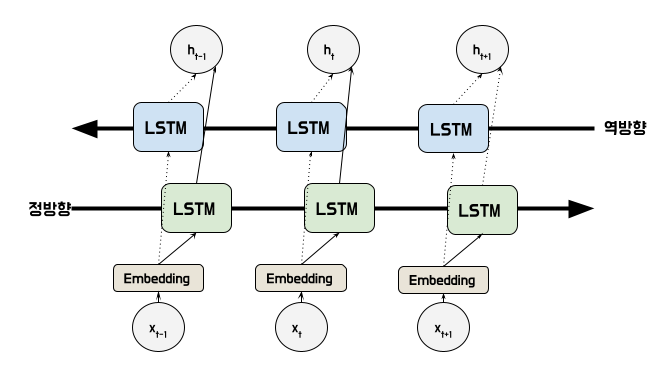

### Keras의  양방향 LSTM로 IMDB 리뷰 데이터 분석하기

[Keras documentation: Bidirectional LSTM on IMDB](https://keras.io/examples/nlp/bidirectional_lstm_imdb/)

**준비**

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

max_features = 20000  # 처음 2만개의 단어만 고려합니다
maxlen = 200  # 각 리뷰에 첫 200개의 단어만 고려합니다

**모델 생성**

In [ ]:
# 가변 길이 정수 시퀀스를 입력합니다
inputs = keras.Input(shape=(None,), dtype="int32")
# 128차원 벡터에 각 정수를 포함합니다 
x = layers.Embedding(max_features, 128)(inputs)

# 양항향 LSTMs을 추가합니다
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# 분류기를 추가합니다
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,757,761
Trainable params: 2,757,761
Non-train

IMDB 리뷰 데이터 불러오기

In [ ]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features
)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17473536/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences


모델 학습 및 평가하기

In [ ]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val))

Epoch 1/2
782/782 [==============================] - 522s 654ms/step - loss: 0.0909 - accuracy: 0.9678 - val_loss: 0.4466 - val_accuracy: 0.8564
Epoch 2/2
782/782 [==============================] - 494s 632ms/step - loss: 0.0571 - accuracy: 0.9803 - val_loss: 0.4919 - val_accuracy: 0.8533


## 6.3.4 개체명 인식 Named Entity Recognition

개체명 인식을 통해 어떤 문장 안에 인물, 장소, 날짜 등의 단어가 포함되어 있는지를 분석할 수 있습니다. 

<aside>
💡 아이린, 현재 서울의 날씨는 어때?

</aside>

챗봇에게 이와 같은 문장을 물어보면 챗봇은 각각

- 아이린 - 인물
- 현재 - 날짜
- 서울 - 지역

과 같이 개체명을 인식합니다. 

### Bio 표기법

**B**: Beginning - 개체명을 나타내며 ‘B-[개체명의 종류]’에 태그됩니다. 

**I**: Inside - 개체명과 이어진 단어를 나타내며 ‘I-[개체명의 종류]’에 태그됩니다. 

**O**: Outside - 개체명이외에 모든 단어에 태그됩니다. 

<aside>
💡 **하버드 대학교에 다니는 아이린 브라운은 오늘 졸업합니다.**

하버드: B-University     다니: O     아이린: B-Person     오늘: B-Date    졸업: O
대학교: I-University      는: O         브라운: I-Person                               합니다.: O
에: O                                               은: O

</aside>

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

print("전체 샘플 개수: ", len(tagged_sentences))
print('첫번째 샘플 :',tagged_sentences[1])

# 참고자료: https://wikidocs.net/24682

### 학습 평가의 정확도

학습 평가를 확인했을 때 의미있는 태그가 아닌 O 태그가 대부분을 차지하게 되어 실제보다 높은 학습 정확도가 나옵니다. 따라서 개체명 인식에는 **F1 스코어**를 계산하여 성능 평가를 합니다. 

- 정확도: 실제 정답과 얼마나 유사한지 나타냅니다.
- 정밀도: 결과값이 일정하게 분포되어 있는 정도를 나타냅니다.
- 재현율: 실제 정답 중 예측 모델이 정답이라 예측한 것의 비율을 나타냅니다.

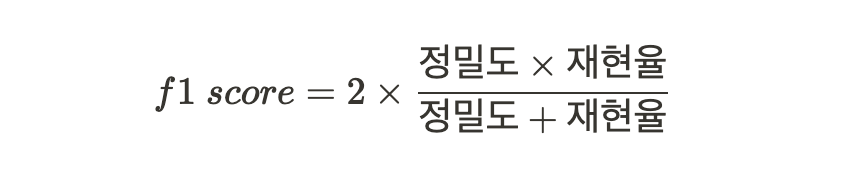

# 마무리

이번 시간에는 Keras를 사용하여 인공신경망에 기초를 탄탄하게 잡아줄 수 있는 **딥러닝 분류 방법, CNN 모델 만들기, RNN과 양방향 LSTM의 비교**까지 해보았습니다! 

다음 시간에는 **데이터베이스 연동**을 하는 방법과 더불어 드디어 **챗봇 학습툴 만들기**를 배워보는 시간을 갖도록 하겠습니다!

감사합니다😊

📍Irene팀의 모든 포스팅은 *처음 배우는 딥러닝 챗봇*을 기반으로 합니다